# Backtest 
This notebook will consist of 3 parts:

1) Backtest for one specific asset
2) Add returns for all backtests to get algo for all assets
3) Optimising the parameters in-sample: LOOKBACK_PERIOD (2 days, 7 days), s-score threshholds (+-1, +-2, +-3,+-4, +-5), close threshold(0x,0.5x,0.75x), stop loss (1.25x, 1.5x, 2x): total = 2x5x3x3 = 90
4) final backtest with out of sample data

### 0) choosing parameters and imports

In [19]:
LOOKBACK_PERIOD = 192
EIGENPORTFOLIO_CUTOFF = 0.55
DRIFT_SENSITIVITY = 2

In [111]:
%load_ext autoreload
%autoreload 2
from SA_OU_helpers import *
from backtest_helpers import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import pandas as pd
import numpy as np
from tqdm import trange, tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Calculating some data beforehand

In [21]:
returns,log_returns, goodness_of_fit, R2_training_all_epochs, R2_forward_all_epochs, returns_res_forward, returns_res_training, Xi_training, Xi_forward, OU_params, eig_portf, s_score_training, s_score_forward, betas_all_epochs,alphas_all_epochs,ret_eigportf_training, ret_eigportf_forward = prepare_data('pct_returns.csv', 'log_returns.csv', LOOKBACK_PERIOD, EIGENPORTFOLIO_CUTOFF,DRIFT_SENSITIVITY)

100%|██████████| 267/267 [00:13<00:00, 19.53it/s]


#### 1) Backtest with transaction costs

Parameters

In [53]:
R2_thresh = 0.8
kappa_thresh = 25
transaction_costs = 0.001
lookback = 192
entry = 3
exit = 1.5
stoploss = 4

The Backtest is based on the following rules:

In [116]:
simulation = backtest(returns.iloc[:50000],s_score_forward,R2_training_all_epochs, OU_params,betas_all_epochs,eig_portf, R2_thresh, kappa_thresh, transaction_costs,lookback, entry, exit, stoploss)
hist1 = simulation.trade_history

50000it [55:07, 15.12it/s]


below a plot of the portfolio value

Total trades: 674
Hitrate: 45.40059347181009%
average win: 9.174776435028248
average loss: -8.851198300136458
stop losses and take profits hit in total:
sl    358
tp    316
Name: descr, dtype: int64
total loss due to transaction costs: 93.43402320231023%


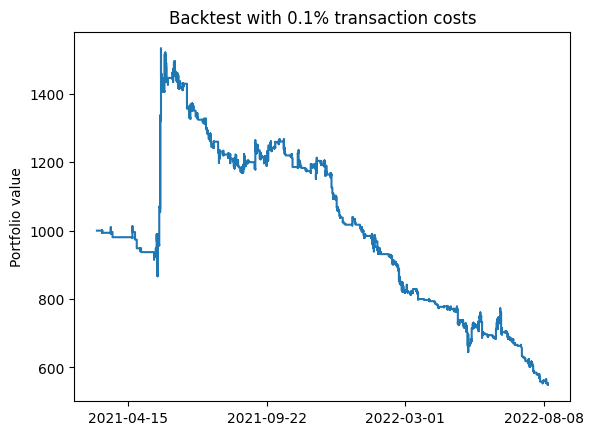

In [162]:
plt.ylabel('Portfolio value')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=160))
plt.plot(pd.to_datetime(simulation.capital.index).date, simulation.capital.values)
print('Total trades: {}'.format(len(hist1)))
print('Hitrate: {}%'.format(len(hist1[hist1.pnl>0]) / len(hist1) *100))
print('average win: {}'.format(hist1[hist1.pnl>0].pnl.mean()))
print('average loss: {}'.format(hist1[hist1.pnl<0].pnl.mean()))
print('stop losses and take profits hit in total:')
print(hist1.descr.value_counts())
ls = 1 - (simulation.transaction_cost_history *-1).cumsum().apply(np.exp).iloc[-1][0]
print('total loss due to transaction costs: {}%'.format(ls*100))
plt.title('Backtest with 0.1% transaction costs')
plt.savefig('backtest_tc.png')

#### 2) Backtest NO transaction costs

The first backtest looks very promising, a transaction cost of 0.1% seems correct

In [121]:
R2_thresh = 0.8
kappa_thresh = 25
transaction_costs = 0.00
lookback = 192
entry = 3
exit = 1.5
stoploss = 4

In [122]:
simulation2 = backtest(returns.iloc[:50000],s_score_forward,R2_training_all_epochs, OU_params, betas_all_epochs,eig_portf, R2_thresh, kappa_thresh, transaction_costs,lookback, entry, exit, stoploss)
hist2 = simulation2.trade_history

50000it [54:19, 15.34it/s]


Total trades: 674
Hitrate: 53.85756676557863%
average win: 41.075621704356294
average loss: -24.13194142956618
stop losses and take profits hit in total:
sl    358
tp    316
Name: descr, dtype: int64
total loss due to transaction costs: 0.0%


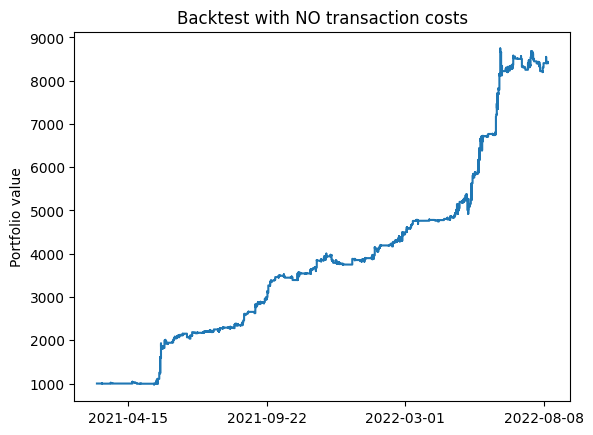

In [163]:
plt.ylabel('Portfolio value')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=160))
plt.plot(pd.to_datetime(simulation2.capital.index).date, simulation2.capital.values)
print('Total trades: {}'.format(len(hist2)))
print('Hitrate: {}%'.format(len(hist2[hist2.pnl>0]) / len(hist2) *100))
print('average win: {}'.format(hist2[hist2.pnl>0].pnl.mean()))
print('average loss: {}'.format(hist2[hist2.pnl<0].pnl.mean()))
print('stop losses and take profits hit in total:')
print(hist2.descr.value_counts())
ls = 1 - (simulation2.transaction_cost_history *-1).cumsum().apply(np.exp).iloc[-1][0]
print('total loss due to transaction costs: {}%'.format(ls*100))
plt.title('Backtest with NO transaction costs')
plt.savefig('backtest_no_tc.png')

In [110]:
np.exp((hist2.apply(lambda row: norm(row.positions,1), axis=1) * -0.001).sum())

0.5029647574824605

In [158]:
rf = 0.03
ret = (simulation.capital / simulation.capital.shift(1)).dropna().cap.values.astype(float)
ret = np.log(ret) 
mean = ret.mean() * 4*12*30*12
std = ret.std()* np.sqrt(4*12*30*12)
sharpe = (mean -np.log(1+rf))/ std 

In [159]:
sharpe

-1.2343690723640992

In [160]:
rf = 0.03
ret2 = (simulation2.capital / simulation2.capital.shift(1)).dropna().cap.values.astype(float)
ret2 = np.log(ret2) 
mean2 = ret2.mean() * 4*12*30*12
std2 = ret2.std()* np.sqrt(4*12*30*12)
sharpe2 = (mean2 -np.log(1+rf))/ std2

In [161]:
sharpe2

3.808975945924047